In [33]:
#Importing necessary packages
import os
import requests
import matplotlib
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn.apionly as sns
from statsmodels.api import OLS
import matplotlib.pyplot as plt
from sklearn import preprocessing
from pandas.core import datetools
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [34]:
#Setting up workspace
url = 'https://github.com/ThomasShayHill/Miami/blob/master/Miami%20Sales%20with%20Elevation%20AG%20107K%20indexed%201971.xlsx?raw=true'
Miami_SF = pd.read_excel(url)

In [35]:
#Removing unnecessary predictors
predictors = list(Miami_SF.columns.values)

predictors.remove('X')
predictors.remove('Zip_5char')
predictors.remove('date_sale_1_num')
predictors.remove('date_sale_2_num')
predictors.remove('price_relative')
predictors.remove('Address') 
predictors.remove('Zip')
predictors.remove('Assessed')
predictors.remove('Bath')
predictors.remove('Stories')
predictors.remove('Units')
predictors.remove('Sale_Date_1')
predictors.remove('Sale_Date_2')
predictors.remove('Sale_Amount_2')
predictors.remove('Total_Appreciation')
predictors.remove('By_Year')
predictors.remove('City')
predictors.remove('Old_Land_Use_Categories')
predictors.remove('price_relative_ind')
predictors.remove('Bed')
predictors.remove('New_Land_Use')
predictors.remove('Sale_Amount_1')

In [36]:
#Setting up for Linear regression
msk = np.random.rand(len(Miami_SF)) < 0.5
data_train = Miami_SF[msk]
data_test = Miami_SF[~msk]

y_train = data_train['price_relative_ind'].values
x_train = data_train[predictors]
y_test = data_test['price_relative_ind'].values
x_test = data_test[predictors]

In [37]:
#Regression results using SKLearn
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(x_train,y_train)
print("The R^2 on the train set using sklearn is ", regression_model.score(x_train, y_train))
print("The R^2 on the test set using sklearn is ",regression_model.score(x_test,y_test))

The R^2 on the train set using sklearn is  0.033564250355
The R^2 on the test set using sklearn is  0.0287357150722


In [38]:
#Regression results using Statsmodels
mod = sm.OLS(y_train, x_train)
linear = mod.fit()
linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     5714.
Date:                Wed, 13 Dec 2017   Prob (F-statistic):               0.00
Time:                        17:34:41   Log-Likelihood:                -89917.
No. Observations:               53854   AIC:                         1.798e+05
Df Residuals:                   53851   BIC:                         1.799e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
YearBuilt      0.0003    1.1e-05     25.357      0.000       0.000       0.000
LivingSqFt  2.856e-05    6.5e-06      4.390      0.000    1.58e-05    4.13e-05
Elevation      0.0572      0.008      7.053      0.000       0.041       0.073
==============================================================================
Omnibus:                    78044.397   Durbin-Watson:                   1.544
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         40881391.400
Skew:                           8.639   Prob(JB):                         0.00
Kurtosis:                     136.866   Cond. No.                     4.18e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

QUESTION: Why is the R^2 using Stats Models' Linear Regression SO much higher than the R^2 using SKLearn? The datasets are exactly the same. 

In [39]:
#Linear Mixed Effects
md = smf.mixedlm('price_relative_ind~Elevation+YearBuilt+LivingSqFt',data=Miami_SF,groups='City',re_formula = '~Elevation')
mdf = md.fit()
print(mdf.summary())

/Users/thomashill/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   price_relative_ind
No. Observations:     107984    Method:               REML              
No. Groups:           33        Scale:                1.7464            
Min. group size:      5         Likelihood:           -183529.4711      
Max. group size:      58804     Converged:            Yes               
Mean group size:      3272.2                                            
------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                    25.093    1.409  17.810 0.000 22.331 27.854
Elevation                     1.450    1.354   1.071 0.284 -1.203  4.103
YearBuilt                    -0.013    0.000 -51.615 0.000 -0.014 -0.013
LivingSqFt                    0.000    0.000  20.816 0.000  0.000  0.

QUESTION: Why does the "Elevation" predictor have a higher p-value in the mixed linear model above than in the StatsModels linear regression from the cell before? 

In [40]:
mdf.random_effects

{'Aventura': Intercept    1.099319
 Elevation   -1.336699
 dtype: float64, 'Bal Harbour': Intercept    3.813173
 Elevation   -3.855579
 dtype: float64, 'Bay Harbor Islands': Intercept    0.675212
 Elevation   -0.782227
 dtype: float64, 'Biscayne Park': Intercept    1.304851
 Elevation   -1.521228
 dtype: float64, 'Coral Gables': Intercept    1.569770
 Elevation   -1.591724
 dtype: float64, 'Cutler Bay': Intercept    1.346520
 Elevation   -1.473511
 dtype: float64, 'Doral': Intercept    1.636288
 Elevation   -1.684415
 dtype: float64, 'El Portal': Intercept    1.214709
 Elevation   -1.562697
 dtype: float64, 'Golden Beach': Intercept    1.227148
 Elevation   -1.334412
 dtype: float64, 'Hialeah': Intercept    1.393258
 Elevation   -1.394579
 dtype: float64, 'Hialeah Gardens': Intercept    2.124940
 Elevation   -1.934954
 dtype: float64, 'Indian Creek': Intercept   -41.214586
 Elevation    42.381725
 dtype: float64, 'Key Biscayne': Intercept    0.408190
 Elevation   -0.111207
 dtype: floa

QUESTION: I'm a bit confused. Does the coefficient printed next to "Elevation" in each line of the mdf.random_effects results (printed below) equal the slope assigned to elevation for each group (City)? That would seem logical....but plotting the predicted values versus this intercept/slope for each city seems to contradict this interpretation. See code and plots below. 

In [41]:
#Zipping LME results into a dataframe
Cities = list(set(Miami_SF['City']))
Cities_set = []
for c in Cities:
    City_properties = Miami_SF[Miami_SF['City']==c]
    if len(City_properties)>500:
        Cities_set.append(c)

effects_intercept = []
effects_slope = []
for i in Cities_set:
    effects_intercept.append(mdf.random_effects[i][0])
    effects_slope.append(mdf.random_effects[i][1])

Cities_Random_Effects = pd.DataFrame(
        {'Cities': Cities_set,
         'Random Intercept': effects_intercept,
         'Random Slope': effects_slope})

Cities_Random_Effects = Cities_Random_Effects.sort_values(['Random Slope'])

#Cities Random Effects Dictionary
re_zip = zip(effects_intercept, effects_slope)
Cities_RE_dict = dict(zip(Cities_set,re_zip))

In [42]:
#Getting predicted and actual values for each city
Yhats_list = []
for i in Cities_set:
    dataset = Miami_SF[Miami_SF['City']==i]
    city_elevs = dataset['Elevation']
    yhats = mdf.predict(dataset)
    actual = dataset['price_relative_ind']
    city_coefs = pd.DataFrame({
            'Elevations': city_elevs,
            'Fitted Values': yhats,
            'Actual Values': actual})
    Yhats_list.append(city_coefs)
Yhats_dict = dict(zip(Cities_set,Yhats_list))

In [58]:
def plot_fitted_values(city):
    x = Yhats_dict[city]['Elevations']
    y = Yhats_dict[city]['Fitted Values']

    # Find the slope and intercept of the best fit line
    intercept, slope = Cities_RE_dict[city][0],Cities_RE_dict[city][1]

    # Create a list of values in the best fit line
    abline_values = [slope * i + intercept for i in x]

    plt.scatter(x, y)
    plt.plot(x, abline_values, 'r')
    plt.title(str(city))
    plt.xlabel('Elevation')
    plt.ylabel('Price Appreciation')
    #plt.savefig(str(city)+' Elevation and Appreciation')
    #plt.show()
    #plt.gcf().clear()

#for i in Cities_set:
#    plot_fitted_values(i)

In [59]:
def plot_actual_values(city):
    x = Yhats_dict[city]['Elevations']
    y = Yhats_dict[city]['Actual Values']

    # Find the slope and intercept of the best fit line
    intercept, slope = Cities_RE_dict[city][0],Cities_RE_dict[city][1]

    # Create a list of values in the best fit line
    abline_values = [slope * i + intercept for i in x]

    plt.scatter(x, y)
    plt.plot(x, abline_values, 'r')
    plt.title(str(city))
    plt.xlabel('Elevation')
    plt.ylabel('Price Appreciation')
    #plt.savefig(str(city)+' Elevation and Appreciation')
    #plt.show()
    #plt.gcf().clear()

#for i in Cities_set:
#    plot_actual_values(i)

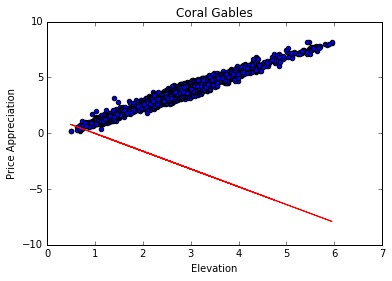

In [63]:
plot_fitted_values('Coral Gables')

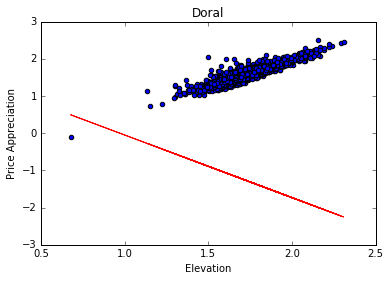

In [64]:
plot_fitted_values('Doral')

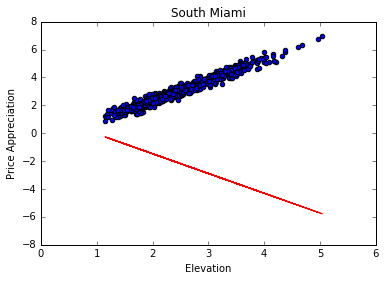

In [65]:
plot_fitted_values('South Miami')

QUESTION: Why do the fitted values appear to be precisely opposite of the trends indicated in the slope?